# Import and inspect data

In [1]:
import nltk
import requests
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# downloading 4 years data from 2022-01-10 to 2018-01-04) using govt api 
Train_data_URL = 'https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2022-10-01&date_received_min=2018-04-01&field=all&format=csv&no_aggs=true&size=1969571&sort=created_date_desc'

# downloading 6 months data from 2023-01-04 to 2022-02-10 using govt api
Test_data_URL  = 'https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2023-04-01&date_received_min=2022-10-02&field=all&format=csv&no_aggs=true&size=532067&sort=created_date_desc'

r = requests.get(Train_data_URL)
open('train_data.csv', 'wb').write(r.content)

r = requests.get(Test_data_URL)
open('test_data.csv', 'wb').write(r.content)


368368399

In [2]:
#Using Data frame to load data
df_orig = pd.read_csv('train_data.csv')
df_test_orig = pd.read_csv('test_data.csv')

In [3]:
df = df_orig.copy()
df_test = df_test_orig.copy()

**Data Inspection**

In [4]:
# Counting the number of NaN values in the df
count_nan = df['Consumer complaint narrative'].isnull().sum()
 
# printing the number of values present in the column
print('Number of NaN values present: ' + str(count_nan))

# dropping rows which have no narrative (1142848 rows)
df = df.dropna(subset=['Consumer complaint narrative'])

Number of NaN values present: 1142952


In [5]:
# Picking "Product ,Consumer complaint narrative" for the modelling
df = df[['Product', 'Consumer complaint narrative']]
# Columns renamed for easy access
df = df.rename(columns={"Product": "product",  "Consumer complaint narrative": "narrative"})
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    461267
Debt collection                                                                 127330
Credit card or prepaid card                                                      70468
Mortgage                                                                         53256
Checking or savings account                                                      47193
Money transfer, virtual currency, or money service                               23263
Vehicle loan or lease                                                            16819
Student loan                                                                     15700
Payday loan, title loan, or personal loan                                        11323
Name: product, dtype: int64

Text(0.5, 1.0, 'Catogary distribution')

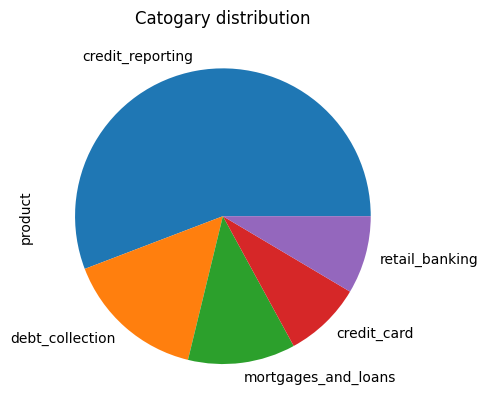

In [19]:
catogary_count = df['product'].value_counts()
plot = catogary_count.plot(kind='pie')
plot.set_title("Catogary distribution")

In [6]:
# Aggrigating product column to easily categorise for the modelling
df['product'].replace({'Credit reporting, credit repair services, or other personal consumer reports': 'credit_reporting',
                       'Debt collection': 'debt_collection',
                       'Credit card or prepaid card': 'credit_card',
                       'Mortgage': 'mortgage',
                       'Checking or savings account': 'retail_banking',
                       'Money transfer, virtual currency, or money service': 'retail_banking',
                       'Vehicle loan or lease': 'loans',
                       'Payday loan, title loan, or personal loan': 'loans',
                       'Student loan': 'loans'}, inplace=True)

#Merging mortgage and loans together as they are in less percentage and almost belong to same category
df['product'].replace({'mortgage': 'mortgages_and_loans',
                       'loans': 'mortgages_and_loans'}, inplace=True)
df['product'].value_counts()

credit_reporting       461267
debt_collection        127330
mortgages_and_loans     97098
credit_card             70468
retail_banking          70456
Name: product, dtype: int64

In [7]:
# Define stopwords, punctuations, and special characters to remove from the text
stopwords_punctuations = set(stopwords.words('english')).union(set(string.punctuation)).union(['--', 'xxxx', "''", '""', '...', '``'])

# Initialize WordNetLemmatizer for lemmatizing the words
lemmatizer = WordNetLemmatizer()

# Function to process text data
def process_text(text):
    # Tokenize the text data
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords, punctuations, and special characters
    sw_punct_rmd = [token.lower() for token in tokens if token.lower() not in stopwords_punctuations and token.isalpha()]
    
    # Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in sw_punct_rmd]
    
    # Join the words into a single string and return
    processed_text = ' '.join(lemmatized_words)
    return processed_text

tqdm.pandas()
df['processed_narrative'] = df['narrative'].progress_apply(process_text)

df.head()

100%|██████████| 826619/826619 [26:46<00:00, 514.52it/s]


,product,narrative,processed_narrative
0,mortgages_and_loans,On XX/XX/2019 I made a monthly loan payment to...,made monthly loan payment pnc bank branch mana...
3,debt_collection,"On XX/XX/XXXX, I received a voicemail message ...",received voicemail message later identified wo...
8,credit_reporting,I have recently discovered that there is unaut...,recently discovered unauthorized information n...
9,credit_reporting,I check my Experian credit report on a monthly...,check experian credit report monthly basis app...
12,retail_banking,I opened a citibank checking account on XXXX X...,opened citibank checking account tried transfe...


In [8]:
df.to_parquet('processed_narrative.parquet')

**Test Data Preparation**

In [10]:
df_test.shape

(532070, 18)

In [11]:
# dropping rows which have no narrative (358643 rows)
df_test = df_test.dropna(subset=['Consumer complaint narrative'])

In [12]:
df_test.shape

(177508, 18)

In [13]:
# Picking "Product ,Consumer complaint narrative" for the modelling
df_test = df_test[['Product', 'Consumer complaint narrative']]
# Columns renamed for easy access
df_test = df_test.rename(columns={"Product": "product",  "Consumer complaint narrative": "narrative"})
df_test['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    125237
Debt collection                                                                  13084
Checking or savings account                                                      11905
Credit card or prepaid card                                                      11126
Mortgage                                                                          6025
Money transfer, virtual currency, or money service                                3529
Vehicle loan or lease                                                             3162
Student loan                                                                      1899
Payday loan, title loan, or personal loan                                         1541
Name: product, dtype: int64

In [14]:
df_test.shape

(177508, 2)

In [15]:
# Aggrigating product column to easily categorise for the modelling

df_test['product'].replace({'Credit reporting, credit repair services, or other personal consumer reports': 'credit_reporting',
                       'Credit reporting': 'credit_reporting',
                       'Debt collection': 'debt_collection',
                       'Credit card or prepaid card': 'credit_card',
                       'Prepaid card': 'credit_card',
                       'Credit card': 'credit_card',
                       'Mortgage': 'mortgage',
                       'Checking or savings account': 'retail_banking',
                       'Money transfer, virtual currency, or money service': 'retail_banking',
                       'Other financial service':'retail_banking',
                       'Virtual currency':'retail_banking',
                       'Money transfers':'retail_banking',
                       'Bank account or service': 'retail_banking',
                       'Vehicle loan or lease': 'loans',
                       'Consumer Loan': 'loans',
                       'Payday loan': 'loans',
                       'Payday loan, title loan, or personal loan': 'loans',
                       'Student loan': 'loans'}, inplace=True)
df_test['product'].replace({'mortgage': 'mortgages_and_loans',
                       'loans': 'mortgages_and_loans'}, inplace=True)
df_test['product'].value_counts()

credit_reporting       125237
retail_banking          15434
debt_collection         13084
mortgages_and_loans     12627
credit_card             11126
Name: product, dtype: int64

In [16]:
df_test['processed_narrative'] = df_test['narrative'].progress_apply(process_text)

100%|██████████| 177508/177508 [05:42<00:00, 517.95it/s]


In [17]:
df_test.to_parquet('processed_narrative_test.parquet')

In [ ]:
https://gv-smdm.s3.amazonaws.com/processed_narrative_test.parquet

https://gv-smdm.s3.amazonaws.com/processed_narrative.parquet